In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [145]:
catalog =  pd.read_csv('../data/catalog.csv', sep='\t')
catalog.drop_duplicates(['SKU'], keep='last', inplace=True)

In [72]:
def read_sales_files(path):
    df = pd.read_csv(path)
    sales_columns = ['date', 'SKU', 'description', 'status', 'style_lvp', 'upc', 'bus', 'units', 'mxn']
    df.columns = sales_columns
    df = df[(~df['SKU'].str.contains('Resultado', na=False))].reset_index(drop=True)
    df['date'] = pd.to_datetime(df['date'], format="%d.%m.%Y")
    df[['SKU', 'units', 'mxn']] = df[['SKU', 'units', 'mxn']].replace(',', '', regex=True).apply(pd.to_numeric, errors='coerce')
    df['bus'] = df['bus'].replace({'BÃ¡sico': 'basics', 'Compra Ãºnica': 'fashion'})
    df.drop(['upc'], axis=1, inplace=True)
    df = df.merge(catalog[['SKU', 'Modelo', 'Marca']], on='SKU', how='left')
    return df.rename({'Modelo': 'style', 'Marca': 'brand'}, axis=1)

In [8]:
sales = read_sales_files('../data/sales_9_1.csv')

In [77]:
def read_oh_files(path):
    df = pd.read_csv(path)
    df = df.iloc[:,[0, 9 ,10]]
    columns = ['SKU', 'oh', 'oo']
    df.columns = columns
    df = df.replace(',', '', regex=True).apply(pd.to_numeric, errors='coerce')
    df['oh'] = df['oh'] + df['oo']
    df.drop(['oo'], axis=1, inplace=True)
    df = df.merge(catalog[['SKU', 'Modelo', 'Marca']], on='SKU', how='left')
    df.dropna(axis=0, how='any', inplace=True)
    return df.rename({'Modelo': 'style', 'Marca': 'brand'}, axis=1)

In [78]:
oh = read_oh_files('../data/liverpool.csv')

In [9]:
start_date = pd.to_datetime('2022.08.31', format='%Y.%m.%d')
bin1_end = pd.to_datetime('2023.08.31', format='%Y.%m.%d')
# bin2_end = pd.to_datetime('2023.08.31', format='%Y.%m.%d')
end_date = pd.to_datetime('2024.08.31', format='%Y.%m.%d')
periods = ['22-23', '23-24']

In [10]:

sales['period'] = pd.cut(sales['date'],
                      bins=[start_date, bin1_end, end_date],
                      labels=periods,
                      right=True)

In [11]:
zero_dates = []

def is_target_date(date):
    return (date.month, date.day) in zero_dates

sales.loc[sales['date'].apply(is_target_date), 'units'] = 0
sales.loc[sales['date'].apply(is_target_date), 'mxn'] = 0


In [12]:
basic_styles = []
for period in periods:
    basic_styles.append(list(sales.loc[(sales['period'] == period) & (sales['bus'] == 'basics'), 'style'].unique()))
basic_styles = list(set.intersection(*map(set, basic_styles)))

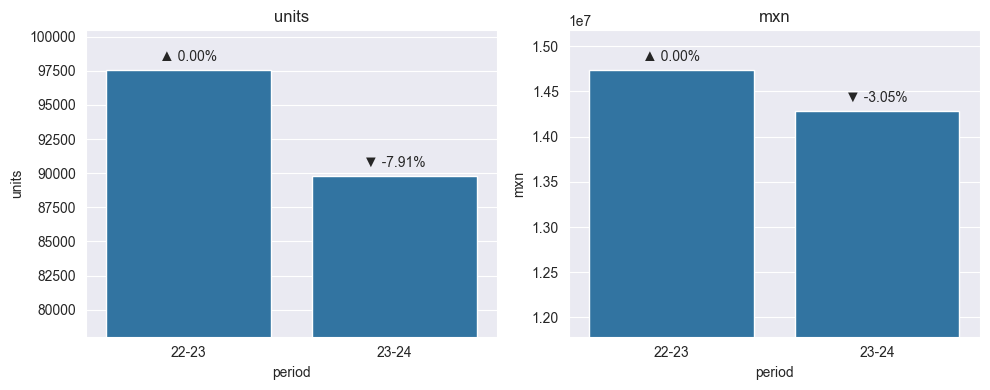

In [152]:
basics = sales[(sales['bus'] == 'basics') & ~(sales['style'].str.contains('2563', na=False))].copy()

plt.figure(figsize=(10, 4))
for i, unit in enumerate(['units', 'mxn']):
    plt.subplot(1, 2, i+1)
    salesp = basics.groupby(['period'], observed=False)[unit].sum().reset_index()
    salesp['growth'] = salesp[unit].pct_change()
    salesp['growth'] = salesp['growth'].fillna(0)
    ax = sns.barplot(x='period', y=unit, data=salesp)
    value_max = salesp[unit].max()
    plt.ylim(value_max * .8, value_max * 1.03)
    for b, (value, growth) in enumerate(zip(salesp[unit], salesp['growth'])):
        triangle = '\u25B2' if growth >= 0 else '\u25BC'
        ax.text(b, value * 1.005, f'{triangle} {growth:.2%}', ha='center', va='bottom')
    plt.title(unit)
    plt.tight_layout()
    plt.savefig(f'plot.png')

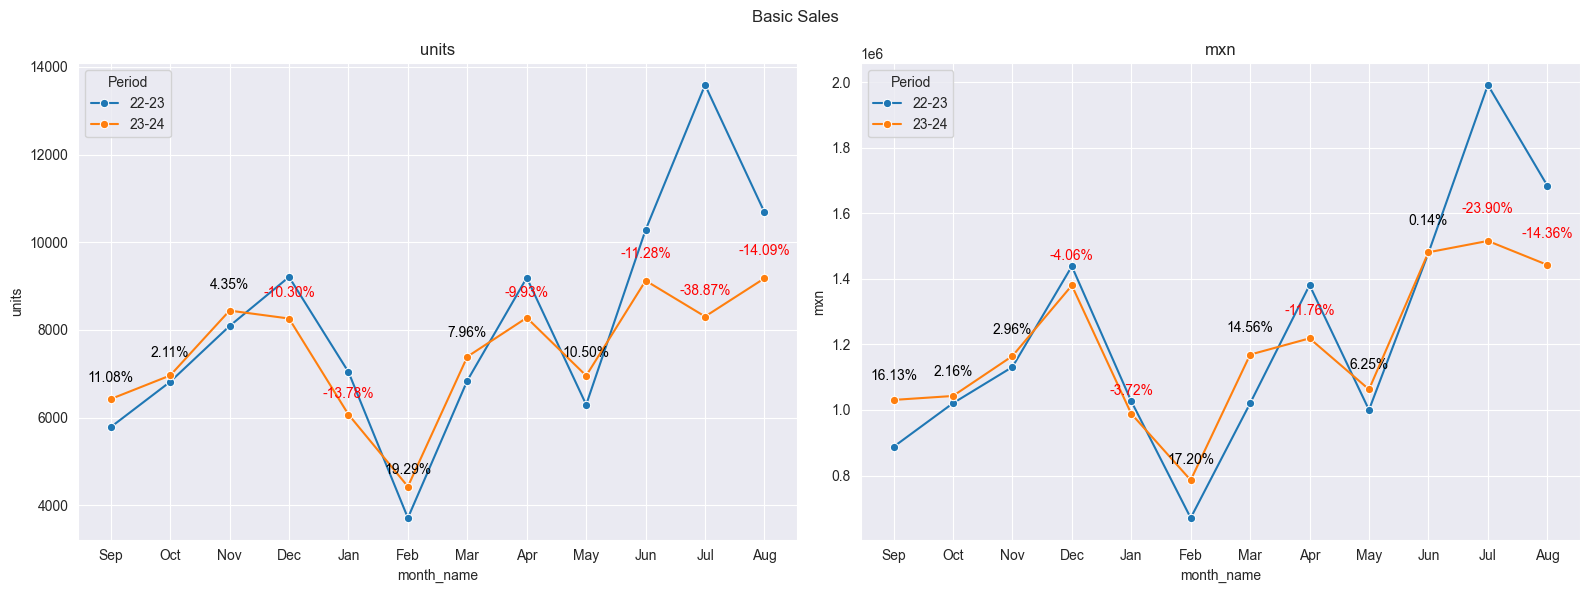

In [157]:
basics['month'] = basics['date'].dt.month
monthly_sales = basics.groupby(['period', 'month'], observed=False)['units'].sum().reset_index()


plt.figure(figsize=(16, 6))
for i, unit in enumerate(['units', 'mxn']):
    monthly_sales = basics.groupby(['period', 'month'], observed=False)[unit].sum().reset_index()
    periods_comparison = monthly_sales['period'].unique()[-2:]
    monthly_sales = monthly_sales[monthly_sales['period'].isin(periods_comparison)]
    monthly_sales['yoy_growth'] = monthly_sales.groupby('month', observed=False)[unit].pct_change()
    monthly_sales['yoy_growth'] = monthly_sales['yoy_growth'].fillna(0)
    custom_month_order = [9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8]
    month_names = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
    month_mapping = dict(zip(custom_month_order, month_names))
    monthly_sales['month'] = pd.Categorical(monthly_sales['month'], categories=custom_month_order, ordered=True)
    monthly_sales['month_name'] = monthly_sales['month'].map(month_mapping)
    
    monthly_sales = monthly_sales.sort_values(['period', 'month'])
    plt.subplot(1, 2, i+1)
    for period in monthly_sales['period'].unique():
        period_data = monthly_sales[monthly_sales['period'] == period]
        sns.lineplot(data=period_data, x='month_name', y=unit, marker='o', label=period)
    for g, row in monthly_sales.iterrows():
        if row['period'] == '23-24':
            color = 'black' if row["yoy_growth"] >= 0 else 'red'
            plt.text(row['month_name'], row[unit]*1.05, f'{row["yoy_growth"]:.2%}', 
                     ha='center', va='bottom', fontsize=10, color=color)
    plt.legend(title='Period')
    plt.suptitle('Basic Sales')
    plt.title(unit)
    plt.tight_layout()
    plt.savefig(f'plot.png')

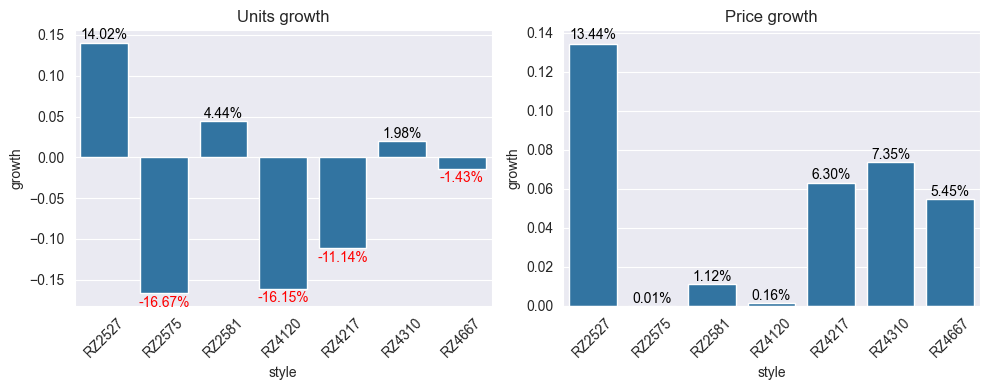

In [158]:
base = '22-23'
new = '23-24'

bbs = basics[(basics['style'].notna()) & (basics['units'].notna()) & (basics['units'] != 0)].reset_index(drop=True).copy()
bbs['style_group'] = [x.rsplit('-', 2)[0] for x in bbs['style']]
bbs['price'] = bbs['mxn'] / bbs['units']

plt.figure(figsize=(10, 4))
for i, unit in enumerate(['units', 'price']):
    plt.subplot(1, 2, i+1)
    df_pivot = pd.pivot_table(bbs, 
                             values=unit, 
                             index='style_group', 
                             columns='period', 
                             aggfunc='sum', 
                             fill_value=0, observed=True).reset_index(names='style')
    df_pivot['growth'] = df_pivot['23-24'] / df_pivot['22-23'] -1
    ax = sns.barplot(x='style', y='growth', data=df_pivot)
    value_max = df_pivot['growth'].max()
    # plt.ylim(value_max * .8, value_max * 1.03)
    for b, growth in enumerate(df_pivot['growth']):
        color = 'black' if growth >= 0 else 'red'
        position = growth * 1.005 if growth >= 0 else (growth - 0.02)
        ax.text(b, position, f'{growth:.2%}', ha='center', va='bottom', color=color)
    plt.title(f'{unit.capitalize()} growth')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'plot.png')

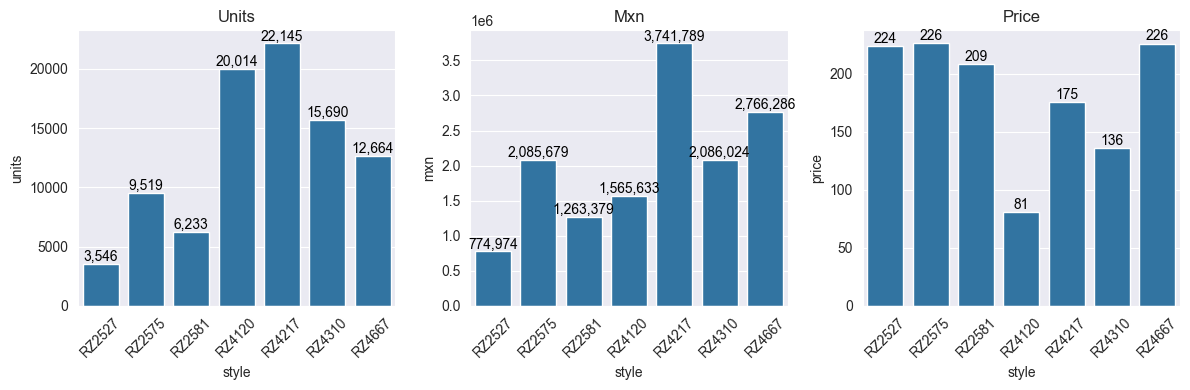

In [182]:
base = '22-23'
new = '23-24'

b12 = basics[(basics['style'].notna()) & (basics['units'].notna()) & (basics['units'] != 0) & (basics['period'] == new)].reset_index(drop=True).copy()
b12['style'] = [x.rsplit('-', 2)[0] for x in b12['style']]
b12['price'] = b12['mxn'] / b12['units']

plt.figure(figsize=(12, 4))
for i, unit in enumerate(['units', 'mxn', 'price']):
    plt.subplot(1, 3, i+1)
    if unit == 'price':
        b12_plot = b12.groupby(['style'])[unit].mean().reset_index()
    else:
        b12_plot = b12.groupby(['style'])[unit].sum().reset_index()
    ax = sns.barplot(x='style', y=unit, data=b12_plot)
    # plt.ylim(value_max * .8, value_max * 1.03)
    for b, u in enumerate(b12_plot[unit]):
        color = 'black'
        position = u + 0.05
        ax.text(b, position, f'{u:,.0f}', ha='center', va='bottom', color=color)
    plt.title(f'{unit.capitalize()}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'plot.png')

In [79]:
inventory = pd.read_csv('../data/inventory.csv', sep='\t')
inventory.columns = ['style', 'brand', 'inv_units', 'received', 'delivered']
order = pd.read_csv('../data/order.csv', sep='\t')
order.columns = ['style', 'ord_units']

In [ ]:
from functools import reduce

In [113]:
date = '2024-06-01'
months_to_may = 9
basics_ly = basics[(basics['period'] == '23-24') & ~(basics['style'].str.contains('2563', na=False)) & (basics['date'] < date)].copy()
basics_lys = basics_ly.groupby('style', observed=False)['units'].sum().reset_index()
basics_lys['sales_ly'] = basics_lys['units']
dfs = [basics_lys.drop(['units'], axis=1), inventory[['style', 'inv_units']], order, oh[['style', 'oh']]]
moi_df = reduce(lambda  left,right: pd.merge(left,right,on=['style'],
                                            how='left'), dfs).fillna(0)
moi_df['inventory'] = moi_df['ord_units'] + moi_df['inv_units']


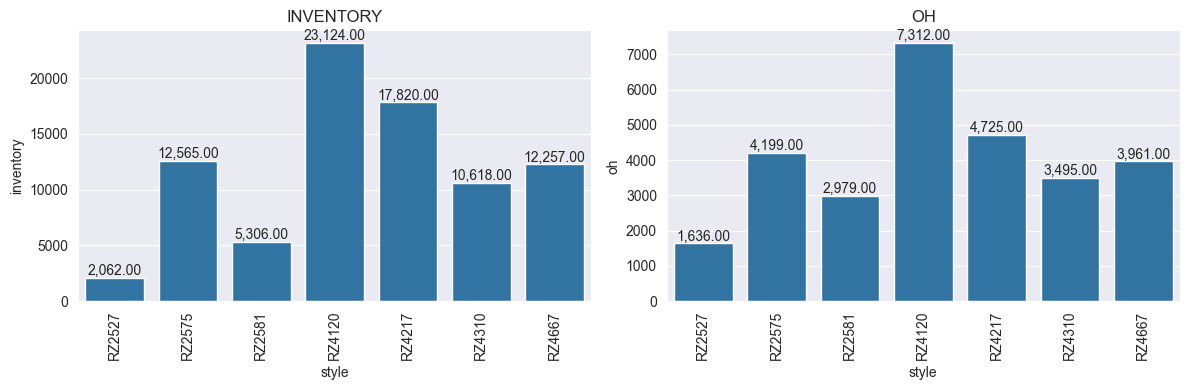

In [171]:
plt.figure(figsize=(12, 4))
for i, unit in enumerate(['inventory', 'oh']):
    plt.subplot(1, 2, i+1)
    moi_plot = moi_df.copy()
    moi_plot['style'] = [x.rsplit('-', 2)[0] for x in moi_plot['style']]
    moi_plot = moi_plot.groupby('style', observed=False).agg({'sales_ly': 'sum', unit: 'sum'}).reset_index()
    moi_plot['moi'] = moi_plot[unit] / (moi_plot['sales_ly'] / months_to_may)
    ax = sns.barplot(x='style', y=unit, data=moi_plot)
    for b, (moi, inv) in enumerate(zip(moi_plot['moi'], moi_plot[unit])):
        # color = 'black' if growth >= 0 else 'red'
        # position = growth * 1.005 if growth >= 0 else (growth - 0.02)
        ax.text(b, inv + 0.005, f'{inv:,.2f}', ha='center', va='bottom')
    plt.title(f'{unit.upper()}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f'plot.png')

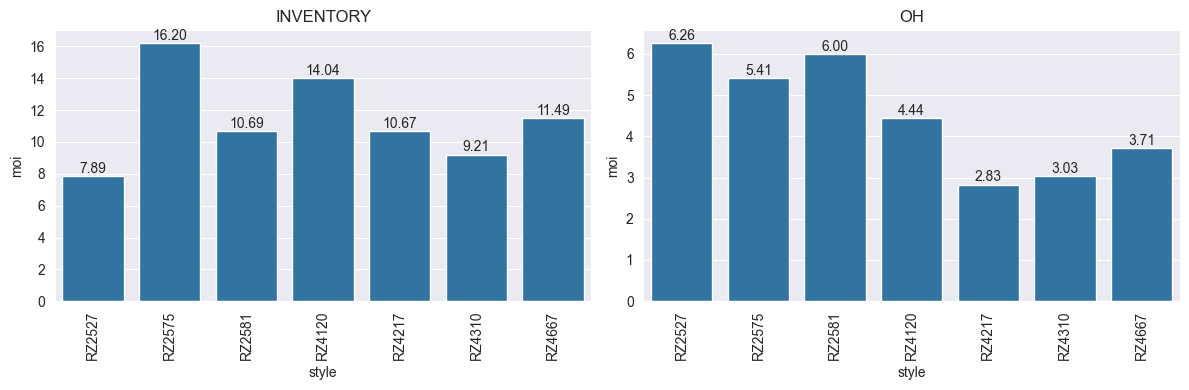

In [159]:
plt.figure(figsize=(12, 4))
for i, unit in enumerate(['inventory', 'oh']):
    plt.subplot(1, 2, i+1)
    moi_plot = moi_df.copy()
    moi_plot['style'] = [x.rsplit('-', 2)[0] for x in moi_plot['style']]
    moi_plot = moi_plot.groupby('style', observed=False).agg({'sales_ly': 'sum', unit: 'sum'}).reset_index()
    moi_plot['moi'] = moi_plot[unit] / (moi_plot['sales_ly'] / months_to_may)
    ax = sns.barplot(x='style', y='moi', data=moi_plot)
    for b, moi in enumerate(moi_plot['moi']):
        # color = 'black' if growth >= 0 else 'red'
        # position = growth * 1.005 if growth >= 0 else (growth - 0.02)
        ax.text(b, moi + 0.005, f'{moi:.2f}', ha='center', va='bottom')
    plt.title(f'{unit.upper()}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f'plot.png')

In [146]:
moi_final = moi_df.copy()
moi_final['unit_final'] = moi_final['inventory'] - moi_final['sales_ly']
moi_final.loc[moi_final['unit_final'] < 0, 'unit_final'] = 0
moi_final = pd.merge(moi_final, catalog.drop_duplicates(subset=['Modelo'], keep='last').rename(columns={'Modelo': 'style', 'Precio': 'wp'})[['style', 'wp']], on='style')
moi_final['wp'] = moi_final['wp'].str.replace('[\$,]', '', regex=True).astype(float)
moi_final['value_final'] = moi_final['unit_final'] * moi_final['wp']

In [147]:
moi_final = moi_final.copy()
moi_final['style'] = [x.rsplit('-', 2)[0] for x in moi_final['style']]

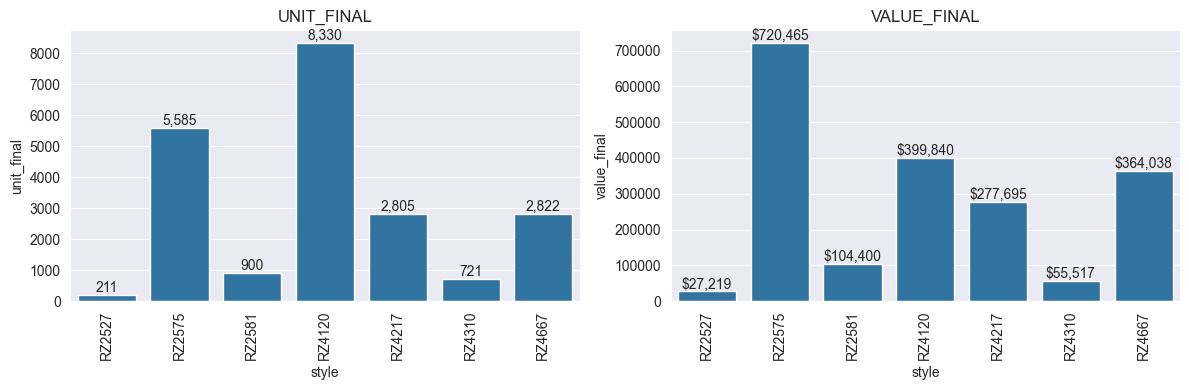

In [162]:


plt.figure(figsize=(12, 4))
for i, unit in enumerate(['unit_final', 'value_final']):
    plt.subplot(1, 2, i+1)
    moi_final_plot = moi_final.groupby('style', observed=False).agg({unit: 'sum'}).reset_index()
    ax = sns.barplot(x='style', y=unit, data=moi_final_plot)
    for b, final in enumerate(moi_final_plot[unit]):
        if unit == 'value_final':
            ax.text(b, final + 0.005, f'${final:,.0f}', ha='center', va='bottom')
        else:
            ax.text(b, final + 0.005, f'{final:,.0f}', ha='center', va='bottom')

    plt.title(f'{unit.upper()}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f'plot.png')

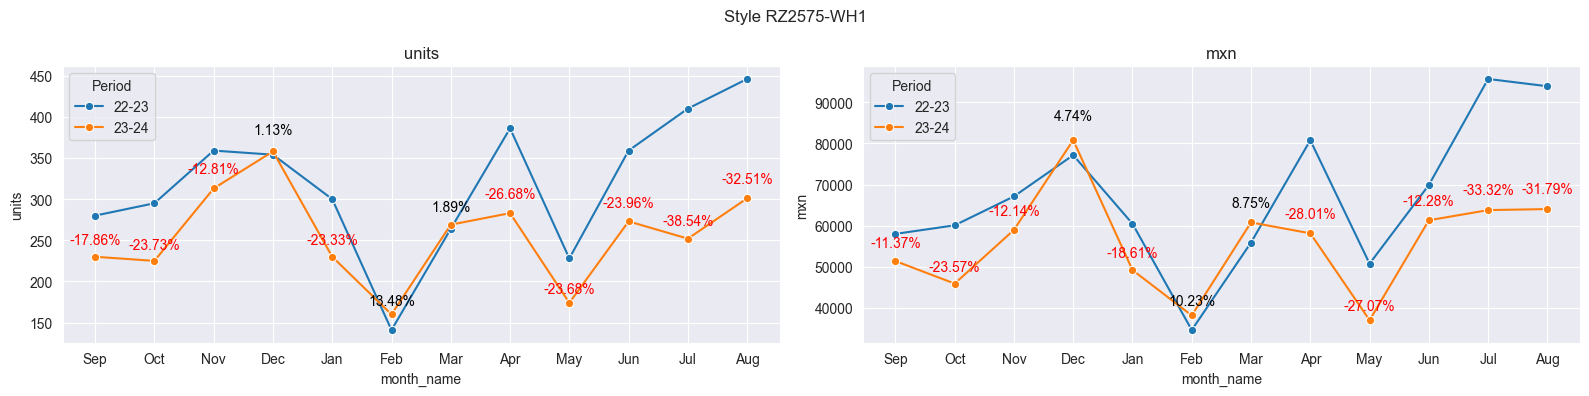

In [67]:
plt.figure(figsize=(16, 6))
for i, unit in enumerate(['units', 'mxn']):
    b2575wh1 = basics[basics['style'].str.contains('2575-WH1',na=False)].copy()
    monthly_sales = b2575wh1.groupby(['period', 'month'], observed=False)[unit].sum().reset_index()
    periods_comparison = monthly_sales['period'].unique()[-2:]
    monthly_sales = monthly_sales[monthly_sales['period'].isin(periods_comparison)]
    monthly_sales['yoy_growth'] = monthly_sales.groupby('month', observed=False)[unit].pct_change()
    monthly_sales['yoy_growth'] = monthly_sales['yoy_growth'].fillna(0)
    custom_month_order = [9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8]
    month_names = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
    month_mapping = dict(zip(custom_month_order, month_names))
    monthly_sales['month'] = pd.Categorical(monthly_sales['month'], categories=custom_month_order, ordered=True)
    monthly_sales['month_name'] = monthly_sales['month'].map(month_mapping)
    
    monthly_sales = monthly_sales.sort_values(['period', 'month'])
    plt.subplot(1, 2, i+1)
    for period in monthly_sales['period'].unique():
        period_data = monthly_sales[monthly_sales['period'] == period]
        sns.lineplot(data=period_data, x='month_name', y=unit, marker='o', label=period)
    for g, row in monthly_sales.iterrows():
        if row['period'] == '23-24':
            color = 'black' if row["yoy_growth"] >= 0 else 'red'
            plt.text(row['month_name'], row[unit]*1.05, f'{row["yoy_growth"]:.2%}', 
                     ha='center', va='bottom', fontsize=10, color=color)
    plt.legend(title='Period')
    plt.suptitle('Style RZ2575-WH1')
    plt.title(unit)
    plt.tight_layout()

In [149]:
sales['mxn'].sum()

np.float64(65144381.00000001)

In [150]:
basics['mxn'].sum()

np.float64(29016782.43)